# Table of contents
- [Verify GPU](#gpu)
- [Data Pipeline](#pipe)
- [Call VGG16](#vgg)
- [Model evaluation](#eva)
- [Conclusion](#con)

In [24]:
from tensorflow.keras.applications.vgg16 import VGG16
import numpy as np
import sys
import pandas as pd
import sklearn as sk
import tensorflow as tf
from tensorflow import keras
import platform
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import random
import os
import warnings
warnings.filterwarnings('ignore')

print(f'Python platform: {platform.platform()}')
print(f'Tensorflow version: {tf.__version__}')

print()
print(f'python {sys.version}')
print(f'pandas {pd.__version__}')
print(f'scikit-learn {sk.__version__}')
gpu=len(tf.config.list_physical_devices('GPU'))>0
print('GPU is', 'available' if gpu else 'not avail')

Python platform: macOS-14.0-arm64-arm-64bit
Tensorflow version: 2.14.0

python 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:41:52) [Clang 15.0.7 ]
pandas 2.1.1
scikit-learn 1.3.1
GPU is available


In [2]:
def set_random_seed(seed):
    
    '''Random seeds for reproducability'''
    
    random.seed(seed)
    tf.random.set_seed(seed)

In [3]:
set_random_seed(123)

# Verify GPU <a class="anchor" id="gpu"></a>

In [32]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# GPU of my machine that is visible to TensorFlow
print('GPU name:',tf.test.gpu_device_name())

Num GPUs Available:  1
GPU name: /device:GPU:0


2023-10-31 20:28:43.609250: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-31 20:28:43.609272: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Data Pipeline <a class="anchor" id="pipe"></a>

In [4]:
training_notflip = os.listdir('../APZIVA/images/training/notflip')
training_flip = os.listdir('../APZIVA/images/training/flip')
testing_notflip = os.listdir('../APZIVA/images/testing/notflip')
testing_flip = os.listdir('../APZIVA/images/testing/flip')

print(len(training_flip) + len(training_notflip), 'images in training set')
print(f'({len(training_flip)} flipped images and {len(training_notflip)} non-flipped images)')
print()
print(len(testing_flip)+len(testing_notflip),'images in testing set')
print(f'({len(testing_flip)} flipped images and {len(testing_notflip)} non-flipped images)')

2392 images in training set
(1162 flipped images and 1230 non-flipped images)

597 images in testing set
(290 flipped images and 307 non-flipped images)


In [5]:
# Let's resize them to size (224,224)
image_height=224
image_width=224
batch_size=16

train = ImageDataGenerator(rescale=1/255.0,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            validation_split = 0.2)

validation = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)

test = ImageDataGenerator(rescale = 1/255.0)

# create training set
print('Training set:')
train_generator = train.flow_from_directory("images/training",
                                            target_size = (image_height, image_width),
                                            batch_size = batch_size,
                                            class_mode = 'binary',
                                            classes = ['notflip', 'flip'],
                                            subset = 'training',
                                            seed = 11)

# create validation set
print('\nValidation set:')
validation_generator = validation.flow_from_directory("images/training", # same directory as training data
                                        target_size = (image_height, image_width),
                                        batch_size = batch_size,
                                        class_mode = 'binary',
                                        classes = ['notflip', 'flip'],
                                        subset = 'validation', # set as validation data
                                        seed = 12,
                                        shuffle=False)

# create testing set  
print('\nTest set:')
test_generator = test.flow_from_directory("images/testing",
                                          target_size = (image_height, image_width),
                                          batch_size = batch_size,
                                          class_mode = 'binary',
                                          classes = ['notflip', 'flip'],
                                          seed = 13,
                                          shuffle=False)


Training set:
Found 1914 images belonging to 2 classes.

Validation set:
Found 478 images belonging to 2 classes.

Test set:
Found 597 images belonging to 2 classes.


In [6]:
# sanity check
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'notflip': 0, 'flip': 1}
{'notflip': 0, 'flip': 1}
{'notflip': 0, 'flip': 1}


# Call VGG16 <a class="anchor" id="vgg"></a>

In [20]:
# call the pretrained model VGG16 since it has been proved to 
# present the best accuracy compared to the VGG19 and Resnet50
vgg = VGG16(input_shape=(224,224,3), 
            weights='imagenet', 
            include_top=False) # Leave out the last fully connected layer

# Since we don’t have to train all the layers, we make them non_trainable
for layer in vgg.layers:
    layer.trainable = False
    
# Flatten the output layer to 1 dimension
x = Flatten()(vgg.output)

# Add a final sigmoid layer with 1 node for classification output
prediction = Dense(1, activation='sigmoid')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

58889256/58889256 [==============================] - 13s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [21]:
# tell the model what cost and optimization method to use
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# fit the model
with tf.device('/device:GPU:0'):
    model.fit(train_generator,
              validation_data = validation_generator,
              epochs=10,
              batch_size=16)

Epoch 1/10
120/120 [==============================] - 49s 378ms/step - loss: 0.4581 - accuracy: 0.7973 - val_loss: 0.4679 - val_accuracy: 0.7301
Epoch 2/10
120/120 [==============================] - 51s 423ms/step - loss: 0.2160 - accuracy: 0.9284 - val_loss: 0.2075 - val_accuracy: 0.9017
Epoch 3/10
120/120 [==============================] - 57s 475ms/step - loss: 0.1606 - accuracy: 0.9556 - val_loss: 0.1327 - val_accuracy: 0.9498
Epoch 4/10
120/120 [==============================] - 56s 469ms/step - loss: 0.1166 - accuracy: 0.9660 - val_loss: 0.2156 - val_accuracy: 0.8933
Epoch 5/10
120/120 [==============================] - 59s 489ms/step - loss: 0.1004 - accuracy: 0.9739 - val_loss: 0.0968 - val_accuracy: 0.9603
Epoch 6/10
120/120 [==============================] - 60s 497ms/step - loss: 0.0891 - accuracy: 0.9744 - val_loss: 0.1057 - val_accuracy: 0.9456
Epoch 7/10
120/120 [==============================] - 62s 515ms/step - loss: 0.0828 - accuracy: 0.9765 - val_loss: 0.1746 - val_ac

# Model evaluation <a class="anchor" id="eva"></a>

In [22]:
model.evaluate(test_generator)

38/38 [==============================] - 15s 391ms/step - loss: 0.0619 - accuracy: 0.9765


[0.06192483752965927, 0.9765493869781494]

In [25]:
from sklearn.metrics import classification_report

# see how well each class is predicted
preds=model.predict(test_generator)
y_test = test_generator.classes
y_pred = np.where(preds > 0.5, 1, 0)
print(classification_report(y_test, y_pred))

38/38 [==============================] - 10s 255ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       307
           1       1.00      0.96      0.98       290

    accuracy                           0.98       597
   macro avg       0.98      0.98      0.98       597
weighted avg       0.98      0.98      0.98       597



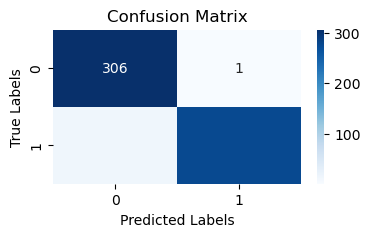

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Create a heatmap plot
plt.figure(figsize=(4,2))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Conclusion <a class="anchor" id="con"></a>

We can see that as compared to the previous regular CNN, the performance of VGG16 is utterly outstanding when only one image is incorrectly classified despite using 10 epochs. And since the size of this dataset is pretty small, the power of transformer is not clearly noticeable when VGG16 has achieved **0.98** of accuracy score and a regular CNN gains **0.95**. However, VGG16 is efficient in terms of running time.